<img src="NotebookAddons/blackboard-banner.png" width="100%" />
<font face="Calibri">
<br>
<font size="7"> <b> GEOS 657: Microwave Remote Sensing<b> </font>

<font size="5"> <b>Lab 9: InSAR Time Series Analysis using GIAnT within Jupyter Notebooks<br>Part 2: GIAnT <font color='rgba(200,0,0,0.2)'> -- [## Points] </font> </b> </font>

<br>
<font size="4"> <b> Franz J Meyer & Joshua J C Knicely; University of Alaska Fairbanks</b> <br>
<img src="NotebookAddons/UAFLogo_A_647.png" width="170" align="right" /><font color='rgba(200,0,0,0.2)'> <b>Due Date: </b>NONE</font>
</font>

<font size="3"> This Lab is part of the UAF course <a href="https://radar.community.uaf.edu/" target="_blank">GEOS 657: Microwave Remote Sensing</a>. This lab is divided into 3 parts: 1) data download and preprocessing, 2) GIAnT time series, and 3) a simple Mogi source inversion. The primary goal of this lab is to demonstrate how to process InSAR data, specifically interferograms, using the Generic InSAR Analysis Toolbox (<a href="http://earthdef.caltech.edu/projects/giant/wiki" target="_blank">GIAnT</a>) in the framework of *Jupyter Notebooks*.<br>

<b>Our specific objectives for this lab are to:</b>

- Prepare data for GIAnT: 
    - Create necessary ancillary files and functions. 
    - Reformat the interferograms. 
- Run GIAnT
- Use GIAnT to create maps of surface deformation: 
    -  Understand its capabilities. 
    -  Understand its limitations. 
</font>

<br>
<font face="Calibri">

<font size="5"> <b> Target Description </b> </font>

<font size="4"> <font color='rgba(200,0,0,0.2)'> <b>THIS NOTEBOOK INCLUDES NO HOMEWORK ASSIGNMENTS.</b></font> <br>

Contact me at fjmeyer@alaska.edu should you run into any problems.
</font>

In [1]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

URLWidget()

In [2]:
from IPython.display import Markdown
from IPython.display import display

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX
if env[0] == '':
    env[0] = 'Python 3 (base)'
if env[0] != '/home/jovyan/.local/envs/insar_analysis':
    display(Markdown(f'<text style=color:red><strong>WARNING:</strong></text>'))
    display(Markdown(f'<text style=color:red>This notebook should be run using the "insar_analysis" conda environment.</text>'))
    display(Markdown(f'<text style=color:red>It is currently using the "{env[0].split("/")[-1]}" environment.</text>'))
    display(Markdown(f'<text style=color:red>Select "insar_analysis" from the "Change Kernel" submenu of the "Kernel" menu.</text>'))
    display(Markdown(f'<text style=color:red>If the "insar_analysis" environment is not present, use <a href="{notebookUrl.split("/user")[0]}/user/{user[0]}/notebooks/conda_environments/Create_OSL_Conda_Environments.ipynb"> Create_OSL_Conda_Environments.ipynb </a> to create it.</text>'))
    display(Markdown(f'<text style=color:red>Note that you must restart your server after creating a new environment before it is usable by notebooks.</text>'))

<font face='Calibri'><font size='5'><b>Overview</b></font>
<br>
<font size='3'><b>About GIAnT</b>
<br>
GIAnT is a Python framework that allows rapid time series analysis of low amplitude deformation signals. It allows users to use multiple time series analysis technqiues: Small Baseline Subset (SBAS), New Small Baseline Subset (N-SBAS), and Multiscale InSAR Time-Series (MInTS). As a part of this, it includes the ability to correct for atmospheric delays by assuming a spatially uniform stratified atmosphere. 
<br><br>
<b>Limitations</b>
<br>
GIAnT has a number of limitations that are important to keep in mind as these can affect its effectiveness for certain applications. It implements the simplest time-series inversion methods. Its single coherence threshold is very conservative in terms of pixel selection. It does not include any consistency checks for unwrapping errors. It has a limited dictionary of temporal model functions. It cannot correct for atmospheric effects due to differing surface elevations. 
<br><br>
<b>Steps to use GIAnT</b><br>
Although GIAnT is an incredibly powerful tool, it requires very specific input. Because of the input requirements, the bulk of the lab and code below is dedicated to getting our data into a form that GIAnT can manipulate and to creating files that tell GIAnT what to do. The general steps to use GIAnT are below. 
<br><br>
More information about GIAnT can be found here, <a href="http://earthdef.caltech.edu/projects/giant/wiki" target="_blank">http://earthdef.caltech.edu/projects/giant/wiki</a>.
<br><br>
- Download Data
- Identify Area of Interest
- Subset (Crop) Data to Area of Interest
- Prepare Data for GIAnT (Today's lab starts here)
    - Adjust file names
    - Remove potentially disruptive default values (optional)
    - Convert data from '.tiff' to '.flt' format
- Create Input Files for GIAnT
    - Create 'ifg.list'
    - Create 'date.mli.par'
    - Make prepxml_SBAS.py
    - Run prepxml_SBAS.py
    - Make userfn.py
- Run GIAnT
    - PrepIgramStack.py
    - ProcessStack.py
    - SBASInvert.py
    - SBASxval.py
- Data Visualization

<br><br>
When you use GIAnT, cite the creator's work using:<br>
Agram et al., (2013). "New Radar Interferometric Time Series Analysis Toolbox Released." Eos Trans. AGU, 94, 69. 
<br>AND<br>
Agram et al., (2012). "Generic InSAR Analysis Toolbox (GIAnT) - User Guide." <http://earthdef.caltech.edu>
<br><br><b><i>DO WE NEED TO ALSO GIVE ASF A CITATION???</i></b>

<font face='Calibri'><font size='5'><b>Required Files</b></font>
<br>
<font size='3'>Before we begin, each student should have a specific subset of files with a specific folder structure as described below. If your folder structure differs, the code will need to be modified. 
<br>
- Folder: Corrected Subsets
    - Files: TRAIN corrected unwrapped phase subsets
    - Files: Uncorrected unwrapped phase subsets
- Folder: Ingram Subsets
    - Files: Amplitude subsets
    - Files: Coherence subsets
    - Files: Unwrapped phase (ingram) subsets
        - Theoretically, these are identical to the uncorrected unwrapped phase subsets in the Corrected Subsets folder. 
    
</font></font>

<font face='Calibri'><font size='5'><b>0 System Setup</b></font><br>
    <font size='3'>We will first do some system setup. This involves importing requiesite Python libraries and defining all of our user inputs. </font></font>

<font face='Calibri'><font size='4'><b>0.0 Import Python Packages</b></font><br>
    <font size='3'>Let's import the Python libraries we will need to run this lab. </font></font>

In [3]:
%%capture
import os
import h5py
import shutil
import re
from datetime import date
import glob
import pickle
import pathlib
import subprocess
from math import ceil

from osgeo import gdal
from osgeo import osr
import pandas as pd

%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches as patches  # for Rectangle
plt.rcParams.update({'font.size': 10})

import numpy as np
from numpy import isneginf

from IPython.display import HTML
from matplotlib import animation, rc

import opensarlab_lib as asfn
asfn.jupytertheme_matplotlib_format()

<font face='Calibri' size='4'><b>0.1 Enter an analysis directory prepared in the Part 1 notebook</b></font>

In [4]:
pickle_pth = "part1_pickle"
while True:
    analysis_directory = input("Enter the absolute path to the directory holding your data from Part 1:\n")
    if os.path.exists(f"{analysis_directory}/{pickle_pth}"):
        break
    else:
        print(f"\n{analysis_directory} does not contain {pickle_pth}")
        continue
os.chdir(analysis_directory)
print(f"\nanalysis_directory: {analysis_directory}")

Enter the absolute path to the directory holding your data from Part 1:
 /home/jovyan/GEOS_657_Labs/2019/test



analysis_directory: /home/jovyan/GEOS_657_Labs/2019/test


<font face='Calibri' size='4'><b>0.2 Open our pickle from the Part 1 notebook</b></font>

In [5]:
pickle_pth = "part1_pickle"
if os.path.exists(pickle_pth):
    with open(pickle_pth,'rb') as infile:
        part1_pickle = pickle.load(infile)
    print(f"part1_pickle = {part1_pickle}")
else:
    print('Invalid Path. Did you follow part 1 and generate your pickle?')

part1_pickle = {'ingram_folder': 'ingrams', 'subset_folder': 'ingram_subsets', 'corrected_folder': 'ingram_subsets_converted', 'heading_avg': 192.62619544615384, 'utm': '32627'}


<font face='Calibri' size='4'><b>0.3 Define some important paths</b></font>

In [6]:
ingram_folder = part1_pickle['ingram_folder'] # Location of the original ingram folders
corrected_folder = part1_pickle['corrected_folder'] # Location of the TRAIN corrected subsets
subset_folder = part1_pickle['subset_folder'] # Location of the original (uncorrected) subsets
giant_dir = f'{analysis_directory}/GIAnT' # directory where we will perform GIAnT analysis
giant_data = f'{analysis_directory}/GIAnT_Data' # directory where we will store our data for use by GIAnT
output_dir = f'{analysis_directory}/geotiffs_and_animations'
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

<font face='Calibri'>
    <font size='4'><b>0.4 Decide whether or not to delete old data</b></font>
<br>
<font size='3'>True = delete
<br>
False = save</font>

In [7]:
replace_giant_dir = True # True or False; if True, any folder with the same name will be deleted and recreated. 
replace_giant_data = True
replace_output_dir = True

In [8]:
# set things to find files
unw = '_unw_phase.'
unw_corr = '_unw_phase_corrected.'
corr = '_corr.'
amp = '_amp.'

<font face='Calibri' size='4'><b>0.5 Delete the GIAnT data and working directories if 'replace_* = True'</b></font>

In [9]:
if replace_giant_dir:
    try:
        shutil.rmtree(giant_dir)
    except:
        pass
if replace_giant_data:
    try: 
        shutil.rmtree(giant_data)
    except:
        pass
if replace_output_dir:
    try:
        shutil.rmtree(output_dir)
    except:
        pass
    
# If the GIAnT data and working directories don't exist, create them. 
pathlib.Path(giant_dir).mkdir(parents=True, exist_ok=True)
pathlib.Path(giant_data).mkdir(parents=True, exist_ok=True)
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

<font face='Calibri' size='4'><b>0.7 Load the pickled heading_avg</b></font>

In [10]:
heading_avg = part1_pickle['heading_avg']
print(f"heading_avg = {heading_avg}")

heading_avg = 192.62619544615384


<font face='Calibri' size='4'><b>0.8 Copy a single clipped geotiff into our working GIAnT directory for later data visualization</b></font>

In [11]:
amps = [f for f in os.listdir(subset_folder) if '_amp' in f]
amps.sort()
shutil.copy(os.path.join(subset_folder, amps[0]), giant_dir)
radar_tiff = os.path.join(giant_dir, amps[0])

<font face='Calibri'><font size='5'><b>1. Create Input Files And Code for GIAnT</b></font>
    <br>
    <font size ='3'>Let's create the input files and specialty code that GIAnT requires. These are listed below. 
        <br>
        
- ifg.list
    - List of the interferogram properties including primary and secondary dates, perpendicular baseline, and sensor name. 
- date.mli.par
    - File from which GIAnT pulls requisite information about the sensor. 
    - This is specifically for GAMMA files. When using other interferogram processing techniques, an alternate file is required. 
- prepxml_SBAS.py
    - Python function to create an xml file that specifies the processing options to GIAnT. 
    - This must be modified by the user for their particular application. 
- userfn.py
    - Python function to map the interferogram dates to a phyiscal file on disk. 
    - This must be modified by the user for their particular application. 
    </font>
    </font>

<font face='Calibri' size='4'><b>1.1 Create 'ifg.list' File </b></font>
<br><br>
<font face='Calibri' size='3'><b>1.1.0 Create a list of unwrapped, phase-corrected data</b></font>

In [12]:
files = [f for f in os.listdir(corrected_folder) if f.endswith(f'{unw_corr}tif')] # Just get one of each file name. 
files.sort()
print(len(files))
print(*files, sep="\n")

7
20210904_20210910_unw_phase_corrected.tif
20210904_20210916_unw_phase_corrected.tif
20210910_20210916_unw_phase_corrected.tif
20210910_20210922_unw_phase_corrected.tif
20210916_20210922_unw_phase_corrected.tif
20210916_20210928_unw_phase_corrected.tif
20210922_20210928_unw_phase_corrected.tif


<font face='Calibri' size='3'><b>1.1.1 Create a 4 column text file to communicate network information to GIAnT within the GIAnT folder</b>
<br>
Contains primary date, secondary date, perpendicular baseline, and sensor designation
</font>

In [13]:
reference_dates = []
secondary_dates = []
for file in files:
    reference_dates.append(file[0:8])
    secondary_dates.append(file[9:17])
# Sort the dates according to the primary dates. 
p_dates, s_dates = (list(t) for t in zip(*sorted(zip(reference_dates, secondary_dates))))

with open(os.path.join(giant_dir, 'ifg.list'), 'w') as fid:
    for i, dt in enumerate(p_dates):
        primary_date = dt # pull out Primary Date (first set of numbers)
        secondary_date = s_dates[i] # pull out Secondary Date (second set of numbers)
        bperp = '0.0' # perpendicular baseline. 
        sensor = 'S1' # Sensor designation. 
        
        # write values to the 'ifg.list' file.
        fid.write(f'{primary_date}  {secondary_date}  {bperp}  {sensor}\n')  

<font face='Calibri' size='3'><b>1.1.2 Print ifg.list</b></font>

In [14]:
with open(os.path.join(giant_dir, 'ifg.list'), 'r') as fid: 
    print(fid.read())

20210904  20210910  0.0  S1
20210904  20210916  0.0  S1
20210910  20210916  0.0  S1
20210910  20210922  0.0  S1
20210916  20210922  0.0  S1
20210916  20210928  0.0  S1
20210922  20210928  0.0  S1



<font face='Calibri'><font size='3'>You may notice that the code above sets the perpendicular baseline to a value of 0.0 m. This is not the true perpendicular baseline. That value can be found in metadata file (titled <font face='Courier New'>$<$primary timestamp$>$_$<$secondary timestamp$>$.txt</font>) that comes with the original interferogram. Generally, we would want the true baseline for each interferogram. However, since Sentinel-1 has such a short baseline, a value of 0.0 m is sufficient for our purposes. </font></font>

<font face='Calibri' size='4'> <b>1.2 Create 'date.mli.par' File </b></font> 
<br>
<font face='Calibri' font size='3'> As we are using GAMMA products, we must create a 'date.mli.par' file from which GIAnT will pull necessary information. If another processing technique is used to create the interferograms, an alternate file name and file inputs are required. 
<br><br>
<b>1.2.0 Make a list of paths to all of the unwrapped interferograms</b>
</font>



In [15]:
files = [f for f in os.listdir(corrected_folder) if f.endswith(f'{unw_corr}tif')]
print(len(files))
print(*files, sep="\n")

print(f'\n\nCurrent Working Directory: {os.getcwd()}')
print(f'radar_tiff path: {radar_tiff}')

7
20210910_20210922_unw_phase_corrected.tif
20210916_20210922_unw_phase_corrected.tif
20210904_20210910_unw_phase_corrected.tif
20210904_20210916_unw_phase_corrected.tif
20210910_20210916_unw_phase_corrected.tif
20210916_20210928_unw_phase_corrected.tif
20210922_20210928_unw_phase_corrected.tif


Current Working Directory: /home/jovyan/GEOS_657_Labs/2019/test
radar_tiff path: /home/jovyan/GEOS_657_Labs/2019/test/GIAnT/20210904_20210910_amp.tif


<font face='Calibri' font size='3'><b>1.2.1 Gather metadata required by GIAnT and save it to a date.mli.par file</b></font>

In [16]:
def get_primary_insar_aquisition_date(ingram_name):
    regex = '[0-9]{8}T[0-9]{6}'
    match = re.search(regex, ingram_name)
    if match:
        return match[0]

ds = gdal.Open(radar_tiff, gdal.GA_ReadOnly)

# Get WIDTH (xsize; AKA 'Pixels') and FILE_LENGTH (ysize; AKA 'Lines') information
n_lines = ds.RasterYSize
n_pixels = ds.RasterXSize
ds = None

# Get the center line UTC time stamp; can also be found inside <date>_<date>.txt file
ingram_name = os.listdir(ingram_folder)[0]
tstamp = get_primary_insar_aquisition_date(ingram_name)
c_l_utc = int(tstamp[0:2])*3600 + int(tstamp[2:4])*60 + int(tstamp[4:6])

# radar frequency; speed of light divided by radar wavelength of Sentinel-1 in meters
rfreq = 299792548.0 / 0.055465763 

# write the 'date.mli.par' file
with open(os.path.join(giant_dir, 'date.mli.par'), 'w') as fid:
    # when using GAMMA products, GIAnT requires the radar frequency. Everything else is in wavelength (m) 
    fid.write(f'radar_frequency: {rfreq} \n') 
    # Method from Tom Logan's prepGIAnT code; can also be found inside <date>_<date>.txt file
    fid.write(f'center_time: {c_l_utc} \n') 
    # inside <date>_<date>.txt file; can be hardcoded or set up so code finds it. 
    fid.write(f'heading: {heading_avg} \n')
    # number of lines in direction of the satellite's flight path
    fid.write(f'azimuth_lines: {n_lines} \n')
    # number of pixels in direction perpendicular to satellite's flight path
    fid.write(f'range_samples: {n_pixels} \n')

<font face='Calibri' font size='3'><b>1.2.2 Print the metadata stored in 'date.mli.par'</b></font>

In [17]:
with open(os.path.join(giant_dir, 'date.mli.par'), 'r') as fid:
    print(fid.read())                       

radar_frequency: 5405001784.614411 
center_time: 73269 
heading: 192.62619544615384 
azimuth_lines: 763 
range_samples: 724 



<font face='Calibri'><font size='4'><b>1.3 Create prepxml_SBAS.py Function</b> </font>
<br>
<font size='3'>We will create a prepxml_SBAS.py function and put it into our GIAnT working directory.</font>
</font>

<font face='Calibri'> <font size='3'><b>Necessary prepxml_SBAS.py edits</b></font>
<br>
<font size='3'> GIAnT comes with an example prepxml_SBAS.py, but requries significant edits for our purposes. These alterations have already been made, so we don't have to do anything now, but it is good to know the kinds of things that have to be altered. The details of some of these options can be found in the GIAnT documentation. The rest must be found in the GIAnT processing files themselves, most notably the tsxml.py and tsio.py functions. <br>The following alterations were made:
<br>
- Changed 'example' &#9658; 'date.mli.par'
- Removed 'xlim', 'ylim', 'rxlim', and 'rylim'
    - These are used for clipping the files in GIAnT. As we have already done this, it is not necessary. 
- Removed latfile='lat.map' and lonfile='lon.map'
    - These are optional inputs for the latitude and longitude maps. 
- Removed hgtfile='hgt.map'
    - This is an optional altitude file for the sensor. 
- Removed inc=21.
    - This is the optional incidence angle information. 
    - It can be a constant float value or incidence angle file. 
    - For Sentinel1, it varies from 29.1-46.0&deg;.
- Removed masktype='f4'
    - This is the mask designation. 
    - We are not using any masks for this. 
- Changed unwfmt='RMG' &#9658; unwfmt='GRD'
    - Read data using GDAL. 
- Removed demfmt='RMG'
- Changed corfmt='RMG' &#9658; corfmt='GRD'
    - Read data using GDAL. 
- Changed nvalid=30 -> nvalid=1
    - This is the minimum number of interferograms in which a pixel must be coherent. A particular pixel will be included only if its coherence is above the coherence threshold, cohth, in more than nvalid number of interferograms. 
- Removed atmos='ECMWF'
    - This is an amtospheric correction command. It depends on a library called 'pyaps' developed for GIAnT. This library has not been installed yet. 
- Changed masterdate='19920604' &#9658; masterdate='20161119'
    - Use our actual masterdate. 
    - I simply selected the earliest date as the masterdate.</font>
<br><br>
    <font size='3'><b>1.3.0 Define some prepxml inputs</b>
        <br>
 The reference region and related variables</font></font></font>

In [18]:
use_ref_region = False
filt = 1.0 / 12 # Start with a temporal filter in length of years
ref_region_size = [5, 5]   # Reference region size in Lines and Pixels
ref_region_center = [-0.9, -91.3] # Center of reference region in lat, lon coordinates
rxlim = [0, 10]
rylim = [95, 105]

primary_date = min([amps[i][0:8] for i in range(len(amps))], key=int) # set the primary date.
print(f"Primary Date: {primary_date}")

Primary Date: 20210904


<font face='Calibri'><font size='3'><b>1.3.1 Create the prepxml Python script</b></font>

In [19]:
if use_ref_region == True:
    use_ref = ''
else:
    use_ref = '#'

prepxml_sbas_template = '''
#!/usr/bin/env python
"""Example script for creating XML files for use with the SBAS processing chain. This script is supposed to be copied to the working directory and modified as needed."""

import sys
tsinsar_pth = '/home/jovyan/.local/GIAnT'
if tsinsar_pth not in sys.path:
    sys.path.append(tsinsar_pth)

import tsinsar as ts
import argparse
import numpy as np

def parse():
    parser= argparse.ArgumentParser(description='Preparation of XML files for setting up the processing chain. Check tsinsar/tsxml.py for details on the parameters.')
    parser.parse_args()

parse()
g = ts.TSXML('data')
g.prepare_data_xml(
    '{0}/date.mli.par', proc='GAMMA', 
    {7}rxlim = [{1},{2}], rylim=[{3},{4}],
    inc = 21., cohth=0.10, 
    unwfmt='GRD', corfmt='GRD', chgendian='True', endianlist=['UNW','COR'])
g.writexml('data.xml')


g = ts.TSXML('params')
g.prepare_sbas_xml(nvalid=1, netramp=True, 
    #atmos='NARR', 
    demerr=False, uwcheck=False, regu=True, masterdate='{5}', filt={6})
g.writexml('sbas.xml')


############################################################
# Program is part of GIAnT v1.0                            #
# Copyright 2012, by the California Institute of Technology#
# Contact: earthdef@gps.caltech.edu                        #
############################################################

'''

with open(os.path.join(giant_dir, 'prepxml_SBAS.py'), 'w') as fid:
    fid.write(prepxml_sbas_template.format(giant_dir,
                                           rxlim[0], rxlim[1],
                                           rylim[0], rylim[1],
                                           primary_date, filt,use_ref))

<font face='Calibri'><font size='3'><b>1.3.2 Print the prepxml script</b></font>

In [20]:
with open(os.path.join(giant_dir, 'prepxml_SBAS.py'), 'r') as fid:
    print(fid.read())


#!/usr/bin/env python
"""Example script for creating XML files for use with the SBAS processing chain. This script is supposed to be copied to the working directory and modified as needed."""

import sys
tsinsar_pth = '/home/jovyan/.local/GIAnT'
if tsinsar_pth not in sys.path:
    sys.path.append(tsinsar_pth)

import tsinsar as ts
import argparse
import numpy as np

def parse():
    parser= argparse.ArgumentParser(description='Preparation of XML files for setting up the processing chain. Check tsinsar/tsxml.py for details on the parameters.')
    parser.parse_args()

parse()
g = ts.TSXML('data')
g.prepare_data_xml(
    '/home/jovyan/GEOS_657_Labs/2019/test/GIAnT/date.mli.par', proc='GAMMA', 
    #rxlim = [0,10], rylim=[95,105],
    inc = 21., cohth=0.10, 
    unwfmt='GRD', corfmt='GRD', chgendian='True', endianlist=['UNW','COR'])
g.writexml('data.xml')


g = ts.TSXML('params')
g.prepare_sbas_xml(nvalid=1, netramp=True, 
    #atmos='NARR', 
    demerr=False, uwcheck=False, regu=True, m

<font face='Calibri'><font size='4'><b>1.4 Create userfn.py script</b></font>
<br>
<font size='3'>This file maps the interferogram dates to a physical file on disk. This python file must be in our working directory, <b>/GIAnT</b>.
<br><br>
    <b>1.4.0 Write userfn.py</b>
    </font>

In [21]:
userfn_template = """
#!/usr/bin/env python
import os 

def makefnames(dates1, dates2, sensor):
    dirname = '{0}'
    root = os.path.join(dirname, dates1+'_'+dates2)
    unwname = root+'{1}'+'flt' # for potentially disruptive default values removed. 
    corname = root+'_corr.flt'
    return unwname, corname
"""

with open(os.path.join(giant_dir, 'userfn.py'), 'w') as fid:
    fid.write(userfn_template.format(giant_data, unw_corr))

<font face='Calibri'><font size='3'><b>1.4.1 Print userfn.py</b></font>

In [22]:
with open(os.path.join(giant_dir, 'userfn.py'), 'r') as fid:
    print(fid.read())


#!/usr/bin/env python
import os 

def makefnames(dates1, dates2, sensor):
    dirname = '/home/jovyan/GEOS_657_Labs/2019/test/GIAnT_Data'
    root = os.path.join(dirname, dates1+'_'+dates2)
    unwname = root+'_unw_phase_corrected.'+'flt' # for potentially disruptive default values removed. 
    corname = root+'_corr.flt'
    return unwname, corname



<font face='Calibri'>
<font size='5'> <b> 2. Prepare Data for GIAnT </b> </font>
<br>
<font size='3'> Our resultant files need to be adjusted for input into GIAnT. This involves:
    <ul>
    <li>Adjusting filenames to start with the date</li>
    <li>(Optional) Removing potentially disruptive default values</li>
    <li>Converting data format from '.tif' to '.flt'</li>
    </ul>
</font>
</font>

<font face='Calibri'>
    <font size='4'><b>2.1 Adjust File Names</b></font>
    <font size='3'><br>GIAnT requires the files to have a simple format of <font face='Courier New'>&lt;primary_date&gt;-&lt;secondary_date&gt;_&lt;unwrapped or coherence designation&gt;.tiff</font>.
<br><br>
<font color='green'><b>We already did this step in Part 1, so section 2.1 is just a reminder that it is also a requirement for GIAnT.</b></font>
</font> </font>

<font face='Calibri'> <font size='4'><b>2.2 Remove disruptive default values</b></font> 
    <br>
    <font size='3'>Now we can remove the potentially disruptive default values from the unwrapped interferograms. For this lab, this step is optional. This is because the Sentinel-1 data does not have any of the disruptive default values. However, for other datasources, this may be required.<br>This works by creating an entirely new geotiff with the text <font face='Courier New'>'\_no\_default'</font> added to the file name.
<br><br>
        <b>2.2.0 Write functions to gather and print paths via a wildcard path.</b>
</font>

In [23]:
def get_tiff_paths(paths):
    tiff_paths = glob.glob(paths)
    tiff_paths.sort()
    return tiff_paths

def print_tiff_paths(tiff_paths):
    for p in tiff_paths:
        print(f"{p}\n")

<font face='Calibri'><font size='3'><b>2.2.1 Gather the paths to the uncorrected and corrected unw_phase tifs</b></font>

In [24]:
paths_unc = f"{corrected_folder}/*{unw}tif"
paths_corr = f"{corrected_folder}/*{unw_corr}tif"
files_unc = get_tiff_paths(paths_unc)
files_corr = get_tiff_paths(paths_corr)

print_tiff_paths(files_unc)
print_tiff_paths(files_corr)

ingram_subsets_converted/20210904_20210910_unw_phase.tif

ingram_subsets_converted/20210904_20210916_unw_phase.tif

ingram_subsets_converted/20210910_20210916_unw_phase.tif

ingram_subsets_converted/20210910_20210922_unw_phase.tif

ingram_subsets_converted/20210916_20210922_unw_phase.tif

ingram_subsets_converted/20210916_20210928_unw_phase.tif

ingram_subsets_converted/20210922_20210928_unw_phase.tif

ingram_subsets_converted/20210922_20211004_unw_phase.tif

ingram_subsets_converted/20210928_20211004_unw_phase.tif

ingram_subsets_converted/20210928_20211010_unw_phase.tif

ingram_subsets_converted/20211004_20211010_unw_phase.tif

ingram_subsets_converted/20211004_20211016_unw_phase.tif

ingram_subsets_converted/20211010_20211016_unw_phase.tif

ingram_subsets_converted/20210904_20210910_unw_phase_corrected.tif

ingram_subsets_converted/20210904_20210916_unw_phase_corrected.tif

ingram_subsets_converted/20210910_20210916_unw_phase_corrected.tif

ingram_subsets_converted/20210910_20210922

<font face='Calibri'><font size='3'><b>2.2.2 Decide if you wish to replace dispruptive NaN values with zeros</b>
    <br>
    True = replace NaNs
    <br>
    False = keep NaNs
</font>

In [25]:
replace_nans = False

<font face='Calibri'><font size='3'><b>2.2.3 Write a function to remove disruptive (NaN) values</b></font>

In [26]:
def replace_nan_values(paths):
    for file in paths:
        outfile = os.path.join(analysis_directory, file.replace('.tif','_no_default.tif'))
        cmd = f"gdal_calc.py --calc=\"(A>-1000)*A\" --outfile={outfile} -A {analysis_directory}/{file} --NoDataValue=0 --format=GTIFF"
        subprocess.call(cmd, shell=True)

<font face='Calibri'> <font size='3'><b>2.2.4 Remove files that have potentially disruptive default values.</b> This step will run only if there is a file with '\_no\_default' in the <font face='Courier New' size='2'>corrected_folder</font> directory.</font> </font>

In [27]:
if replace_nans:
    replace_nan_values(files_unc)
    replace_nan_values(files_corr)
    # change 'unw' and 'unw_corr' so the appropriate files will still be found in later code. 
    unw = unw.replace('_unw_phase', '_unw_phase_no_default')
    unw_corr = unw_corr.replace('_corrected', '_corrected_no_default')
else:
    print("Skipping the removal of disruptive values.")

Skipping the removal of disruptive values.


<font face='Calibri'>
<font size='4'><b>2.3 Convert data format from '.tif' to '.flt'</b><br></font>
<font size='3'>This is a requirement of GIAnT
<br><br>
<b>2.3.0 Gather the paths to the files to convert</b></font></font>

In [28]:
# Find the unwrapped phase files to convert. 
paths_unc = f"{corrected_folder}/*{unw}tif"
paths_corr = f"{corrected_folder}/*{unw_corr}tif"
paths_cohr = f"{subset_folder}/*{corr}tif"
files_unc = get_tiff_paths(paths_unc)
files_corr = get_tiff_paths(paths_corr)
files_cohr = get_tiff_paths(paths_cohr)

# file format should appear as below
# YYYYMMDD-YYYYMMDD_unw_phase.flt
# OR, if default values have been removed...
# YYYYMMDD-YYYYMMDD_unw_phase_no_default.flt

print_tiff_paths(files_unc)
print_tiff_paths(files_corr)
print_tiff_paths(files_cohr)

ingram_subsets_converted/20210904_20210910_unw_phase.tif

ingram_subsets_converted/20210904_20210916_unw_phase.tif

ingram_subsets_converted/20210910_20210916_unw_phase.tif

ingram_subsets_converted/20210910_20210922_unw_phase.tif

ingram_subsets_converted/20210916_20210922_unw_phase.tif

ingram_subsets_converted/20210916_20210928_unw_phase.tif

ingram_subsets_converted/20210922_20210928_unw_phase.tif

ingram_subsets_converted/20210922_20211004_unw_phase.tif

ingram_subsets_converted/20210928_20211004_unw_phase.tif

ingram_subsets_converted/20210928_20211010_unw_phase.tif

ingram_subsets_converted/20211004_20211010_unw_phase.tif

ingram_subsets_converted/20211004_20211016_unw_phase.tif

ingram_subsets_converted/20211010_20211016_unw_phase.tif

ingram_subsets_converted/20210904_20210910_unw_phase_corrected.tif

ingram_subsets_converted/20210904_20210916_unw_phase_corrected.tif

ingram_subsets_converted/20210910_20210916_unw_phase_corrected.tif

ingram_subsets_converted/20210910_20210922

<font face='Calibri'><font size='3'><b>2.3.1 Convert the .tif files to .flt files</b>
    <br>
tiff_to_flt creates 3 files: '*.flt', '*.flt.aux.xml', and '*.hdr', where the asterisk, '*', is replaced with the file name</font>

In [29]:
def tiff_to_flt(paths):
    for file in paths:
        newname, old_ext = os.path.splitext(file)
        # Create system command that will convert the file from a .tiff to a .flt
        cmd = f"gdal_translate -of ENVI {file} {file.replace('.tif','.flt')}"
        try:
            #print(f"cmd = {cmd}") # display what the command looks like. 
            # pass command to the system
            subprocess.call(cmd, shell=True)
        except: 
            print(f"Problem with command: {cmd}")
    print("Conversion from '.tif' to '.flt' complete.")
    
tiff_to_flt(files_unc)
tiff_to_flt(files_corr)
tiff_to_flt(files_cohr)

Conversion from '.tif' to '.flt' complete.
Conversion from '.tif' to '.flt' complete.
Conversion from '.tif' to '.flt' complete.


<font face = 'Calibri' size='3'><b>2.3.1 Gather the paths to the '\*.flt', '\*.hdr', and '\*.aux.xml' files</b></font>

In [30]:
paths_flt = f"*/*.flt"
paths_hdr = f"*/*.hdr"
paths_aux = f"*/*.flt.aux.xml"

files_flt = get_tiff_paths(paths_flt)
files_hdr = get_tiff_paths(paths_hdr)
files_aux = get_tiff_paths(paths_aux)

print_tiff_paths(files_flt)
print_tiff_paths(files_hdr)
print_tiff_paths(files_aux)

ingram_subsets/20210904_20210910_corr.flt

ingram_subsets/20210904_20210916_corr.flt

ingram_subsets/20210910_20210916_corr.flt

ingram_subsets/20210910_20210922_corr.flt

ingram_subsets/20210916_20210922_corr.flt

ingram_subsets/20210916_20210928_corr.flt

ingram_subsets/20210922_20210928_corr.flt

ingram_subsets/20210922_20211004_corr.flt

ingram_subsets/20210928_20211004_corr.flt

ingram_subsets/20210928_20211010_corr.flt

ingram_subsets/20211004_20211010_corr.flt

ingram_subsets/20211004_20211016_corr.flt

ingram_subsets/20211010_20211016_corr.flt

ingram_subsets_converted/20210904_20210910_unw_phase.flt

ingram_subsets_converted/20210904_20210910_unw_phase_corrected.flt

ingram_subsets_converted/20210904_20210916_unw_phase.flt

ingram_subsets_converted/20210904_20210916_unw_phase_corrected.flt

ingram_subsets_converted/20210910_20210916_unw_phase.flt

ingram_subsets_converted/20210910_20210916_unw_phase_corrected.flt

ingram_subsets_converted/20210910_20210922_unw_phase.flt

ingra

<font face='Calibri'><font size='3'><b>2.3.2 Move the files and delete the extraneous '.flt.aux.xml' files</b></font>

In [31]:
def move_list_of_files(paths, new_analysis_directory):
    for file in paths:
        path, name = os.path.split(file)
        try:
            shutil.move(file,os.path.join(new_analysis_directory, name))
        except FileNotFoundError as e:
            raise type(e)(f"Failed to find {file}")

move_list_of_files(files_flt, giant_data)
move_list_of_files(files_hdr, giant_data)

for file in files_aux:
    os.remove(file)

<font face='Calibri'> <font size='4'> <b>2.4 Run prepxml_SBAS.py </b> </font>
<br>
    <font size='3'> Here we run <b>prepxml_SBAS.py</b> to create the 2 needed files

- data.xml 
- sbas.xml

To use MinTS, we would create and run <b>prepxml_MinTS.py</b> to create

- data.xml
- mints.xml
        
These files are needed by <b>PrepIgramStack.py</b>. 
</font>
<br><br>
<font size='3'><b>Define the path to the GIAnT module, change into giantDir, and run prepxml_SBAS.py</b>
<br>
Note: We have to change into giant_dir due to GIAnT's use of relative paths to find expected files.
<br><br>
<b>2.4.0 Define the path to the GIAnT installation and move into giant_dir (in your analysis directory)</b></font>

In [32]:
giant_path = "/home/jovyan/.local/GIAnT/SCR"

#install cython (replaces weave. Needed for running GIAnT in Python 3)
# !pip install --user cython

try:
    os.chdir(giant_dir)
except FileNotFoundError as e:
    raise type(e)(f"Failed to find {file}")
    
print(f"current directory: {os.getcwd()}\n")
for file in glob.glob('*.*'):
    print(file)

current directory: /home/jovyan/GEOS_657_Labs/2019/test/GIAnT

date.mli.par
prepxml_SBAS.py
20210904_20210910_amp.tif
ifg.list
userfn.py


<font face='Calibri' size='3'><b>2.4.1 Download GIAnT from the asf-jupyter-data S3 bucket</b>
    <br>
    GIAnT is no longer supported (Python 2). This unofficial version of GIAnT has been partially ported to Python 3 to run this notebook. Only the portions of GIAnT used in this notebook have been tested.
    </font>

In [33]:
if not os.path.exists("/home/jovyan/.local/GIAnT"):
    download_path = 's3://asf-jupyter-data/GIAnT_5_21.zip'
    output_path = f"/home/jovyan/.local/{os.path.basename(download_path)}"
    !aws --region=us-east-1 --no-sign-request s3 cp $download_path $output_path
    if os.path.isfile(output_path):
        !unzip $output_path -d /home/jovyan/.local/
        os.remove(output_path)

<font face='Calibri'><font size='3'><b>2.4.2 Run prepxml_SBAS.py</b></font>

In [34]:
!python prepxml_SBAS.py

logger - INFO - GIANT Toolbox - v 1.0
logger - INFO - ---------------------
prepare_data_xml - INFO - Using GAMMA products
addsubelement - INFO - Creating Field: proc , Value=GAMMA, Type=STR
addsubelement - INFO - Creating Field: width , Value=724, Type=INT
addsubelement - INFO - Creating Field: file_length , Value=763, Type=INT
addsubelement - INFO - Creating Field: wavelength , Value=0.055465763, Type=FLOAT
addsubelement - INFO - Creating Field: heading , Value=192.62619544615384, Type=FLOAT
addsubelement - INFO - Creating Field: utc , Value=73269, Type=INT
addsubelement - INFO - Creating Field: mask , Value=, Type=STR
addsubelement - INFO - Creating Field: cthresh , Value=0.1, Type=FLOAT
addsubelement - INFO - Creating Field: latfile , Value=, Type=STR
addsubelement - INFO - Creating Field: lonfile , Value=, Type=STR
addsubelement - INFO - Creating Field: hgtfile , Value=, Type=STR
addsubelement - INFO - Creating Field: incidence , Value=21.0, Type=FLOAT
addsubelement - INFO - Creat

<font face='Calibri' size='3'><b>2.4.3 View the newly created data.xml</b></font>

In [35]:
with open('data.xml', 'r') as f:
    print(f.read())

<data>
  <proc>
    <value>GAMMA</value>
    <type>STR</type>
    <help>Processor used for generating the interferograms.</help>
  </proc>
  <master>
    <width>
      <value>724</value>
      <type>INT</type>
      <help>WIDTH of the IFGs to be read in.</help>
    </width>
    <file_length>
      <value>763</value>
      <type>INT</type>
      <help>FILE_LENGTH of the IFGS to be read in.</help>
    </file_length>
    <wavelength>
      <value>0.055465763</value>
      <type>FLOAT</type>
      <help>WAVELENGTH of the Stack. If combining sensors,ensure that they are all converted to same units.</help>
    </wavelength>
    <heading>
      <value>192.62619544615384</value>
      <type>FLOAT</type>
      <help>Heading of the satellite in degrees. Manually adjust for Doris.</help>
    </heading>
    <utc>
      <value>73269</value>
      <type>INT</type>
      <help>Average time of acquisition in seconds of the day</help>
    </utc>
    <mask>
      <value></value>
      <type>STR</type>
 

<font face='Calibri' size='3'><b>2.4.4 View the newly created 'sbas.xml'</b></font>

In [36]:
with open('sbas.xml', 'r') as f:
    print(f.read())

<params>
  <proc>
    <nvalid>
      <value>1</value>
      <type>INT</type>
      <help>Minimum number of coherent IFGs for a single pixel. If zero, pixel should be coherent in all IFGs.</help>
    </nvalid>
    <uwcheck>
      <value>False</value>
      <type>BOOL</type>
    </uwcheck>
    <netramp>
      <value>True</value>
      <type>BOOL</type>
      <help>Network deramp. Remove ramps from IFGs in a network sense.</help>
    </netramp>
    <gpsramp>
      <value>False</value>
      <type>BOOL</type>
      <help>GPS deramping. Use GPS network information to correct ramps.</help>
    </gpsramp>
    <stnlist>
      <value></value>
      <type>STR</type>
      <help>Station list for position of GPS stations.</help>
    </stnlist>
    <stntype>
      <value></value>
      <type>STR</type>
      <help>Type of station list. False for Sopac, True for (Name,Lat,Lon), velocity for (Name,lat,lon,ve,vn,vu)</help>
    </stntype>
    <gpspath>
      <value></value>
      <type>STR</type>
     

<font face='Calibri'><font size='5'><b>3. Run GIAnT</b></font>
    <br>
    <font size='3'>We have now created all of the necessary files to run GIAnT. The full GIAnT process requires 3 function calls.
<ul>
    <li>PrepIgramStack.py</li>
    <li>ProcessStack.py</li>
    <li>SBASInvert.py</li>
</ul>
We will make a 4th function call that is not necessary, but provides some error estimation that can be useful.
<ul>
    <li>SBASxval.py</li>
</ul>
    </font>
    
<font face='Calibri'> <font size='4'> <b>3.0 Run PrepIgramStack.py </b> </font>
<br>
    <font size='3'> Here we run <b>PrepIgramStack.py</b> to create the files for GIAnT. This will read in the input data and the files we previously created. This will output HDF5 files. As we did not have to modify <b>PrepIgramStack.py</b>, we will call from the installed GIAnT library. <br>
Inputs:       
- ifg.list
- data.xml
- sbas.xml        

Outputs:
- RAW-STACK.h5
- PNG previews under 'Igrams' folder 
    
    </font> </font>
<br>
<font face='Calibri' size='3'><b>3.0.0 Display the help information for PrepIgramStack.py</b></font>

In [37]:
!python $giant_path/PrepIgramStack.py -h

logger - INFO - GIANT Toolbox - v 1.0
logger - INFO - ---------------------
usage: PrepIgramStack.py [-h] [-i INAME] [-o ONAME] [-x DXML] [-f FIGS]
                         [-u USERPY]

Reads in unwrapped interferograms and prepares data from time-series
processing. See doc strings in code for details.

optional arguments:
  -h, --help  show this help message and exit
  -i INAME    Text file to be read for interferogram information. Default:
              ifg.list
  -o ONAME    To override the default output HDF5 file. Default: RAW-STACK.h5
  -x DXML     To override the default data xml file. Default: data.xml
  -f FIGS     To override the default directory for creating PNG previews.
              Default:Igrams
  -u USERPY   Stand-alone python script with user-defined function
              (makefnames).


<font face='Calibri' size='3'><b>3.0.1 Run PrepIgramStack.py</b>
<br>
Note: The processing status bar may not fully complete when the script is finished running. This is okay.</font>

In [38]:
!python $giant_path/PrepIgramStack.py -i ifg.list
# The '-i ifg.list' is technically unnecessary as that is the default. 

logger - INFO - GIANT Toolbox - v 1.0
logger - INFO - ---------------------
<module> - INFO - Number of interferograms = 7
<module> - INFO - Number of unique SAR scenes = 5
<module> - INFO - Number of connected components in network: 1
<module> - INFO - No common mask defined
<module> - INFO - Output h5file: Stack/RAW-STACK.h5
<module> - INFO - PNG preview dir: Figs/Igrams
<module> - INFO - Reading in IFGs
[============================ 86% ==================>        ]      5s /      0s 
<module> - INFO - Fixing mask and geometry files.


<font face='Calibri' size='3'><b>3.0.2 Confirm the correct HDF5 file format</b></font>

In [39]:
file = os.path.join('Stack','RAW-STACK.h5')
if not h5py.is_hdf5(file):
    print(f'Not an HDF5 file:{file}')
else:
    print("It's an HDF5 file")

It's an HDF5 file


<font face='Calibri'> <font size='4'> <b>3.1 Run ProcessStack.py </b> </font>
<br>
    <font size='3'> This seems to be an optional step. Does atmospheric corrections and estimation of orbit residuals. <br>
Inputs:

- HDF5 files from PrepIgramStack.py, RAW-STACK.h5
- data.xml 
- sbas.xml
- GPS Data (optional; we don't have this)
- Weather models (downloaded automatically)

Outputs: 

- HDF5 files, PROC-STACK.h5
        
These files are then fed into SBAS. 
</font> </font>
<br><br>
<font face='Calibri' size='3'><b>3.1.0 Display the help information for ProcessStack.py</b></font>

In [40]:
!python $giant_path/ProcessStack.py -h

logger - INFO - GIANT Toolbox - v 1.0
logger - INFO - ---------------------
usage: ProcessStack.py [-h] [-i INAME] [-o ONAME] [-x DXML] [-p PXML]

Processes the stack before inversion - Deramping + Atmospheric correction.

optional arguments:
  -h, --help  show this help message and exit
  -i INAME    To override the default Input HDF5 file. Default: RAW-STACK.h5
  -o ONAME    To override the default Output HDF5 file. Default: PROC-STACK.h5
  -x DXML     To override the default data xml file. Default: data.xml
  -p PXML     To override the default sbas xml file. Default: sbas.xml


<font face='Calibri' size='3'><b>3.1.1 Run ProcessStack.py</b>
<br>
Note: The processing status bars may never fully complete. This is okay.</font>

In [41]:
!python $giant_path/ProcessStack.py

logger - INFO - GIANT Toolbox - v 1.0
logger - INFO - ---------------------
<module> - INFO - Input h5file: Stack/RAW-STACK.h5
<module> - INFO - Output h5file: Stack/PROC-STACK.h5
deramp - INFO - PROGRESS: Estimating individual ramps.
[============================ 71% =========>                 ]      0s /      0s 
deramp - INFO - PROGRESS: Network deramp of IFGs.
[============================ 86% ==================>        ]      0s /      0s 
<module> - INFO - PNG preview of Deramped images: Figs/Ramp
[============================ 71% =========>                 ]      4s /      1s 


<font face='Calibri' size='3'><b>3.1.2 Confirm the correct HDF5 file format</b></font>

In [42]:
file = os.path.join('Stack','PROC-STACK.h5')
#print(files)
if not h5py.is_hdf5(file):
    print(f'Not an HDF5 file:{file}')
else:
    print("It's an HDF5 file!")

It's an HDF5 file!


<font face='Calibri'> <font size='4'> <b>3.2 Run SBASInvert.py </b> </font>
<br>
<font size='3'> Run the time series. 
Inputs
<ul>
    <li>HDF5 file, PROC-STACK.h5</li>
    <li>data.xml</li>
    <li>sbas.xml</li>
</ul>
Outputs
<ul>
    <li>HDF5 file: LS-PARAMS.h5</li>
</ul>

</font> </font>
<br>
<font face='Calibri' size='3'><b>3.2.0 Display the help information for SBASInvert.py</b></font>

In [43]:
!python $giant_path/SBASInvert.py -h

logger - INFO - GIANT Toolbox - v 1.0
logger - INFO - ---------------------
usage: SBASInvert.py [-h] [-i FNAME] [-o ONAME] [-d DXML] [-p PXML]

Simple SBAS inversion script.

optional arguments:
  -h, --help  show this help message and exit
  -i FNAME    To override input HDF5 file. Default: Uses default from
              ProcessStack.py
  -o ONAME    To override output HDF5 file. Default: LS-PARAMS.h5
  -d DXML     To override the data XML file. Default: data.xml
  -p PXML     To override the processing XML file. Default: sbas.xml


<font face='Calibri' size='3'><b>3.2.1 Run SBASInvert.py</b>
<br><br>
Note: The processing status bar may not fully complete when the script is finished running. This is okay.</font>

In [44]:
!python $giant_path/SBASInvert.py

logger - INFO - GIANT Toolbox - v 1.0
logger - INFO - ---------------------
<module> - INFO - Number of interferograms = 7
<module> - INFO - Number of unique SAR scenes = 5
<module> - INFO - Number of connected components in network: 1
Timefn - INFO - Adding 5 linear pieces (SBAS)
<module> - INFO - Output h5file: Stack/LS-PARAMS.h5
[============================================================]      0s /      0s


<font face='Calibri'> <font size='4'> <b>3.3 Run SBASxval.py </b> </font>
<br>
    <font size='3'> Get an uncertainty estimate for each pixel and epoch using a Jacknife test. This is often the most time consuming portion of the code. 
 
Inputs: 
<ul>
    <li>HDF5 files, PROC-STACK.h5</li>
    <li>data.xml</li>
    <li>sbas.xml</li>
</ul>
Outputs:
<ul>
    <li>HDF5 file, LS-xval.h5</li>
        </ul>
</font> </font>
<br>
<font face='Calibri' size='3'><b>3.3.0 Display the help information for SBASxval.py</b></font>

In [45]:
!python $giant_path/SBASxval.py -h

logger - INFO - GIANT Toolbox - v 1.0
logger - INFO - ---------------------
usage: SBASxval.py [-h] [-i FNAME] [-o ONAME] [-d DXML] [-p PXML]

Simple SBAS inversion script.

optional arguments:
  -h, --help  show this help message and exit
  -i FNAME    To override input HDF5 file. Default: Uses default from
              ProcessStack.py
  -o ONAME    To override output HDF5 file. Default: LS-xval.h5
  -d DXML     To override the data XML file. Default: data.xml
  -p PXML     To override the processing XML file. Default: sbas.xml


<font face='Calibri' size='3'><b>3.3.1 Run SBASInvert.py</b>
<br><br>
Note: The processing status bar may not fully complete when the script is finished running. This is okay.</font>

In [46]:
!python $giant_path/SBASxval.py

logger - INFO - GIANT Toolbox - v 1.0
logger - INFO - ---------------------
<module> - INFO - Input h5file: Stack/PROC-STACK.h5
Timefn - INFO - Adding 5 linear pieces (SBAS)
<module> - INFO - Output h5file: Stack/LS-xval.h5
[============================================================]      1s /      0s


<font face='Calibri' size='4'><b>3.4 Having completed our GIAnT processing, return to the analysis' analysis_directory directory</b></font>

In [47]:
os.chdir(analysis_directory)
print(f'Current directory: {os.getcwd()}')

Current directory: /home/jovyan/GEOS_657_Labs/2019/test


<font face='Calibri'><font size='5'><b>4. Data Visualization</b></font>
<br><br>
<font size='4'><b>4.0 Prepare data for visualization</b></font>  
<br>
<font size='3'><b>4.0.0 Load the LS-PARAMS stack produced by GIAnT and read it into an array so we can manipulate and display it.</b></font></font>


In [48]:
filename = os.path.join(giant_dir, 'Stack/LS-PARAMS.h5')
f = h5py.File(filename, 'r')
# List all groups
group_key = list(f.keys()) # get list of all keys. 
print(f"group_key: {group_key}") # print list of keys. 

group_key: ['cmask', 'dates', 'mName', 'masterind', 'parms', 'rawts', 'recons', 'regF', 'tims']


<font face='Calibri' size='3'><b>4.0.1 Display LS-PARAMS info with gdalinfo</b></font>

In [49]:
!gdalinfo {filename}

Driver: HDF5/Hierarchical Data Format Release 5
Files: /home/jovyan/GEOS_657_Labs/2019/test/GIAnT/Stack/LS-PARAMS.h5
Size is 512, 512
Metadata:
  cmask_help=Common pixel mask.
  dates_help=Ordinal values of SAR acquisition dates.
  help=Regular SBAS Inversion results. Raw + filtered series.
  parms_help=Stores all the relevant parameters from the SBAS inversion.
  rawts_help=Raw unfiltered time-series
  recons_help=Reconstructed time-series
  regF_help=regF family indicator for model parameters.
  tims_help=SAR acquisition time in years.
Subdatasets:
  SUBDATASET_1_NAME=HDF5:"/home/jovyan/GEOS_657_Labs/2019/test/GIAnT/Stack/LS-PARAMS.h5"://cmask
  SUBDATASET_1_DESC=[763x724] //cmask (32-bit floating-point)
  SUBDATASET_2_NAME=HDF5:"/home/jovyan/GEOS_657_Labs/2019/test/GIAnT/Stack/LS-PARAMS.h5"://parms
  SUBDATASET_2_DESC=[763x724x4] //parms (32-bit floating-point)
  SUBDATASET_3_NAME=HDF5:"/home/jovyan/GEOS_657_Labs/2019/test/GIAnT/Stack/LS-PARAMS.h5"://rawts
  SUBDATASET_3_DESC=[5x763

<font face='Calibri'><font size='3'><b>4.0.2 Load the LS-xval stack produced by GIAnT and read it into an array so we can manipulate and display it.</b></font></font>

In [50]:
filename = os.path.join(giant_dir, 'Stack/LS-xval.h5')
error = h5py.File(filename, 'r')
# List all groups
error_key = list(error.keys()) # get list of all keys. 
print(f"error_key: {error_key}") # print list of keys. 

error_key: ['cmask', 'dates', 'error', 'mName', 'masterind', 'recons', 'regF', 'tims']


<font face='Calibri' size='3'><b>4.0.3 Display LS-xval info with gdalinfo</b></font>

In [51]:
print(gdal.Info(filename))

Driver: HDF5/Hierarchical Data Format Release 5
Files: /home/jovyan/GEOS_657_Labs/2019/test/GIAnT/Stack/LS-xval.h5
Size is 512, 512
Metadata:
  cmask_help=Common pixel mask.
  dates_help=Ordinal values of SAR acquisition dates.
  error_help=Uncertainty in time-series
  recons_help=Reconstructed time-series
  regF_help=regF family indicator for model parameters.
  tims_help=SAR acquisition time in years.
Subdatasets:
  SUBDATASET_1_NAME=HDF5:"/home/jovyan/GEOS_657_Labs/2019/test/GIAnT/Stack/LS-xval.h5"://cmask
  SUBDATASET_1_DESC=[763x724] //cmask (32-bit floating-point)
  SUBDATASET_2_NAME=HDF5:"/home/jovyan/GEOS_657_Labs/2019/test/GIAnT/Stack/LS-xval.h5"://error
  SUBDATASET_2_DESC=[5x763x724] //error (32-bit floating-point)
  SUBDATASET_3_NAME=HDF5:"/home/jovyan/GEOS_657_Labs/2019/test/GIAnT/Stack/LS-xval.h5"://recons
  SUBDATASET_3_DESC=[5x763x724] //recons (32-bit floating-point)
Corner Coordinates:
Upper Left  (    0.0,    0.0)
Lower Left  (    0.0,  512.0)
Upper Right (  512.0,  

<font face='Calibri'><font size='3'>Details on what each of these keys in group_key and error_key means can be found in the GIAnT documentation. For now, the only keys with which we are concerned are 'recons' (the filtered time series of each pixel) and 'dates' (the dates of acquisition). It is important to note that the dates are given in a type of Julian Day number called Rata Die number which we convert to Gregorian dates below. </font></font>
<br><br>
<font face='Calibri'><font size='3'><b>4.0.4 Get the relevant data and error values from our stacks and confirm that the number of rasters in our data stack, the number of error points, and the number of dates are all the same.</b></font></font>

In [52]:
# Get our data from the stack
data_cube = f['recons'][()]

# Get our error from the stack
error_cube = error['error'][()]

# Get the dates for each raster from the stack
dates = list(f['dates']) # these dates appear to be given in Rata Die style: floor(Julian Day Number - 1721424.5). 

# Check that the number of rasters in the data cube, error cube, and the number of dates are the same. 
if data_cube.shape[0] is not len(dates) or error_cube.shape[0] is not len(dates):
    print('Problem')
    print('Number of rasters in data_cube: ', data_cube.shape[0])
    print('Number of rasters in error_cube: ', error_cube.shape[0])
    print('Number of dates: ', len(dates))
else:
    print('The number of dates and rasters match.')

The number of dates and rasters match.


<font face='Calibri'><font size='3'><b>4.0.5 Convert from Rata Die number (similar to Julian Day number) contained in 'dates' to Gregorian date. </b></font></font>

In [53]:
tindex = []
for d in dates:
    tindex.append(date.fromordinal(int(d)))

<font face='Calibri'><font size='3'><b>4.0.6 Create an amplitude image of the volcano.</b></font></font>

In [54]:
radar = gdal.Open(radar_tiff) # open my radar tiff using GDAL
im_radar = radar.GetRasterBand(1).ReadAsArray() # access the band information
dbplot = np.ma.log10(im_radar) # plot as a log10
dbplot[isneginf(dbplot)] = 0

<font face='Calibri'>
    <font size='4'><b>4.1 Select a Point-of-Interest</b></font>
    <br><br>
    <font size='3'><b>4.1.0 Write a class to create an interactive matplotlib plot that displays an overlay of the clipped deformation map and amplitude image, and allows the user to select a point of interest.</b></font></font>

In [55]:
class pixelPicker:
    def __init__(self, image1, image2, width, height):
        self.x = None
        self.y = None
        self.fig = plt.figure(figsize=(width, height), tight_layout=True)
        self.fig.tight_layout()
        self.ax = self.fig.add_subplot(111, visible=False)
        self.rect = patches.Rectangle(
            (0.0, 0.0), width, height, 
            fill=False, clip_on=False, visible=False,
        )
        self.rect_patch = self.ax.add_patch(self.rect)
        self.cid = self.rect_patch.figure.canvas.mpl_connect(
            'button_press_event',
            self
        )
        self.image1 = image1
        self.image2 = image2
        self.plot = self.defNradar_plot(self.image1, self.image2, self.fig, return_ax=True)
        self.plot.set_title('Select a Point of Interest from db-Scaled Amplitude Image')
        
        
    def defNradar_plot(self, deformation, radar, fig, return_ax=False):
        ax = fig.add_subplot(111)
        vmin = np.percentile(radar, 3)
        vmax = np.percentile(radar, 97)
        im = ax.imshow(radar, cmap='gray', vmin=vmin, vmax=vmax)
        vmin = np.percentile(deformation, 3)
        vmax = np.percentile(deformation, 97)
        fin_plot = ax.imshow(deformation, cmap='RdBu', vmin=vmin, vmax=vmax, alpha=0.75)
        cbar = fig.colorbar(fin_plot, fraction=0.24, pad=0.02)
        cbar.ax.set_xlabel('mm')
        cbar.ax.set_ylabel('Deformation', rotation=270, labelpad=20)
        #ax.set(title="Integrated Defo [mm] Overlaid on Clipped db-Scaled Amplitude Image")
        plt.grid()
        if return_ax:
            return(ax)
    
    
    def __call__(self, event):
        print('click', event)
        self.x = event.xdata
        self.y = event.ydata
        for pnt in self.plot.get_lines():
            pnt.remove()
        plt.plot(self.x, self.y, 'ro')

<font face='Calibri'><font size='3'><b>4.1.1 Create the interactive point of interest plot, and select a point</b></font></font>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
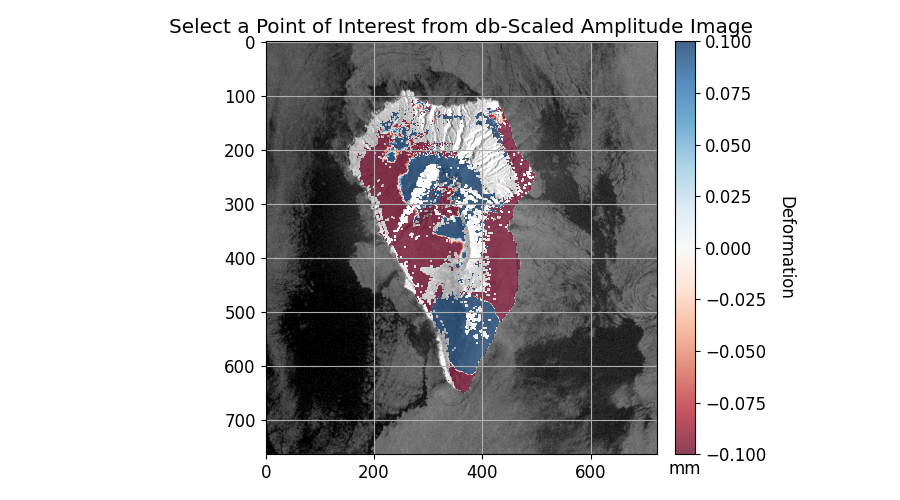

In [56]:
fig_xsize = 9
fig_ysize = 5
deformation = data_cube[data_cube.shape[0]-1]
my_plot = pixelPicker(deformation, dbplot, fig_xsize, fig_ysize)

<font face='Calibri' size='3'><b>4.1.2 Grab the line and pixel for the selected POI</b></font>

In [57]:
my_line = ceil(my_plot.y)
my_pixel = ceil(my_plot.x)
print(f'my_line: {my_line}')
print(f'my_pixel: {my_pixel}')

my_line: 353
my_pixel: 359


<font face='Calibri'>
    <font size='4'><b>4.2 Visualize the data for the selected POI</b></font>
    <br><br>
    <font size='3'><b>4.2.0 Write a function to visualize the time series for a single pixel (POI) as well as the associated error for that pixel.</b></font></font>

In [58]:
def time_series_with_error(deformation, radar, series_d, 
                           series_e, my_line, my_pixel, 
                           tindex, fig_xsize, fig_ysize):
    # Create base figure; 2 rows, 1 column
    fig, axes = plt.subplots(nrows=2, ncols=1,
                             figsize=(fig_xsize,fig_ysize*2),
                             gridspec_kw={'width_ratios':[1],'height_ratios':[1,1]})
    # Plot radar image with deformation in left column with crosshair over pixel of interest
    vmin = np.percentile(radar, 3)
    vmax = np.percentile(radar, 97)
    axes[0].imshow(radar, cmap='gray', vmin=vmin, vmax=vmax, aspect='equal')
    vmin = np.percentile(deformation, 3)
    vmax = np.percentile(deformation, 97)
    fin_plot = axes[0].imshow(deformation, cmap='RdBu', vmin=vmin, vmax=vmax, alpha=0.75, aspect='equal')
    cbar = fig.colorbar(fin_plot, fraction=0.24, pad=0.02, ax=axes[0])
    cbar.ax.set_xlabel('mm')
    cbar.ax.set_ylabel('Deformation', rotation=270, labelpad=20)
    axes[0].set(title="Integrated Defo [mm] Overlain on\nClipped db-Scaled Amplitude Image")
    axes[0].grid() # overlay a grid on the image. 
    
    # Put crosshair over POI in first figure. 
    axes[0].plot(my_pixel, my_line, 'cx', markersize=12, markeredgewidth=4) # create a cyan x ('cx') at location [myPixel,myLine]
    axes[0].legend(labels=['POI']) # Put in a legend with the label 'POI'
    
    # Plot time series of pixel in right column with error bars
    # Make pandas time series object
    ts_d = pd.Series(series_d, index=tindex)
    # Plot the time series object with the associated error. 
    ts_d.plot(marker='.', markersize=6, yerr=series_e)
    axes[1].legend(labels=[f'Time Series for POI at ({my_line}, {my_pixel})'])
    axes[1].set(title="Integrated Defo [mm] with Error Estimates for a Single Pixel")
    plt.xlabel('Date')
    plt.ylabel('Deformation [mm]')
    for tick in axes[1].get_xticklabels():
        tick.set_rotation(90)
    plt.grid() # overlay a grid on the time series plot. 

<font face='Calibri'><font size='3'><b>4.2.1 Plot the time series for the selected POI</b></font></font>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
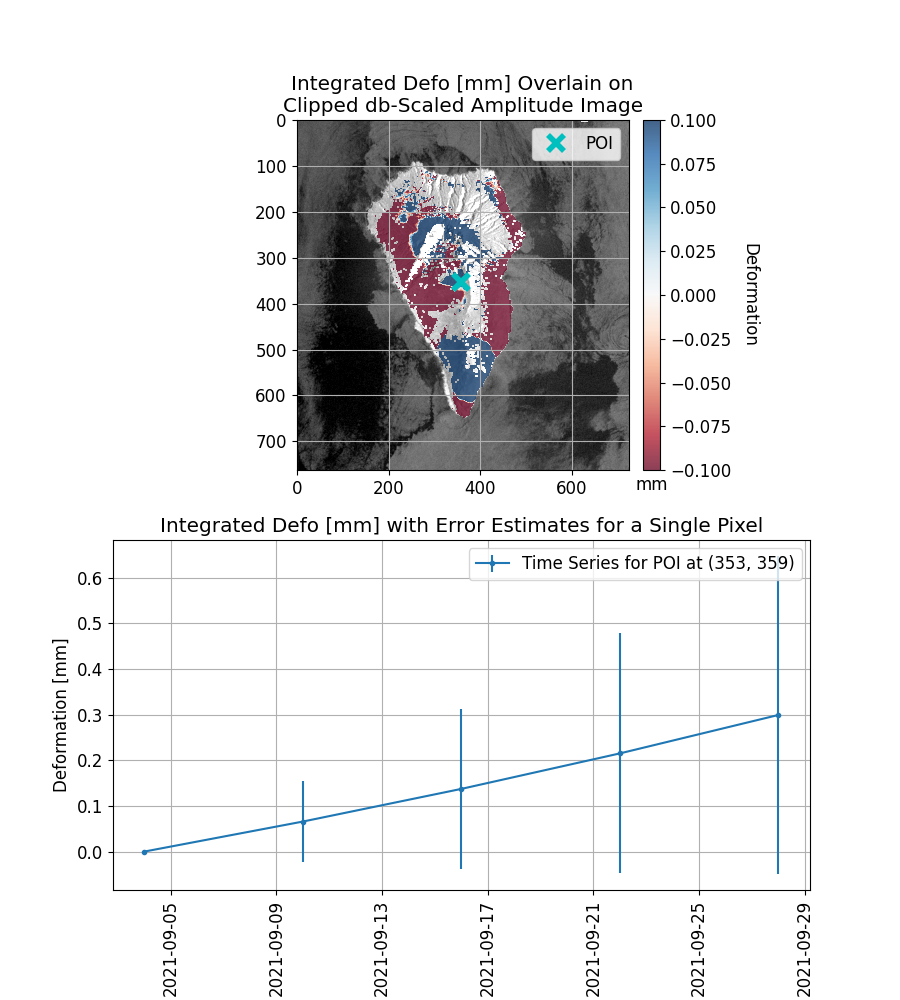

In [59]:
series_d = data_cube[:, my_line, my_pixel]
series_e = error_cube[:, my_line, my_pixel]

time_series_with_error(deformation, dbplot, series_d, 
                       series_e, my_line, my_pixel, 
                       tindex, fig_xsize, fig_ysize)

<font face='Calibri'><font size='3'><b>4.2.2 Create an animation of the deformation</b></font></font>

In [60]:
%%capture
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
#ax.axis('off')
vmin=np.percentile(data_cube.flatten(), 5)
vmax=np.percentile(data_cube.flatten(), 95)


vmin = np.percentile(deformation, 3)
vmax = np.percentile(deformation, 97)
im = ax.imshow(data_cube[0], cmap='RdBu', vmin=vmin, vmax=vmax)
ax.set_title("Animation of Deformation Time Series - Sierra Negra, Galapagos")
cbar = fig.colorbar(im)
cbar.ax.set_xlabel('mm')
cbar.ax.set_ylabel('Deformation', rotation=270, labelpad=20)
plt.grid()

def animate(i):
    ax.set_title("Date: {}".format(tindex[i]))
    im.set_data(data_cube[i])
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=data_cube.shape[0], interval=400)
rc('animation', embed_limit=10.0**9) # set the maximum animation size allowed. 

<font face='Calibri'><font size='3'><b>4.2.3 Display the animation</b></font></font>

In [61]:
HTML(ani.to_jshtml())

<font face='Calibri'><font size='3'><b>Define a prefix to prepend to all output files for identification purposes</b></font></font>

In [62]:
while True:
    prefix = input("Enter an identifiable prefix to prepend to output files: ")
    if re.search('\W', prefix):
        print(f"\n\"{prefix}\" contains invalid characters. Please try again.")
    else:
        break

Enter an identifiable prefix to prepend to output files:  t1


<font face='Calibri'><font size='3'><b>4.2.5 Save the animation as a gif</b></font></font>

In [63]:
ani_path = os.path.join(output_dir, f"{prefix}_filt={filt}_{date.today()}.gif")
ani.save(ani_path, writer='pillow', fps=2)

<font face='Calibri'><font size='3'>Note: 'date.today()' returns the current date from the system on which it is called. As OpenSAR Lab runs in machines on the East coast of the United States, date.today() will return the date based on Eastern Standard Time (EST).</font>
    </font>

<font face='Calibri'><font size='5'><b>5. HDF5 TO GEOTIFF</b></font>
    <br>
    <font size='3'>Convert the HDF5 file to a series of geolocated geotiffs. This method comes from an answer to this <a href="https://gis.stackexchange.com/questions/37238/writing-numpy-array-to-raster-file" target="_blank">StackExchange question</a> which is based on a recipe from the <a href="https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html#create-raster-from-array">Python GDAL/OGR Cookbook</a>.</font>
    <br>
<font size='4'>  
<b>5.0 Display the size of the data-stack</b> 
</font>
</font>

In [64]:
print(f"Number of rasters: {data_cube.shape[0]}")
print(f"Height & Width in Pixels: {data_cube.shape[1]}, {data_cube.shape[2]}")

Number of rasters: 5
Height & Width in Pixels: 763, 724


<font face='Calibri'><font size='4'><b>5.1 Get raster information from one of the subsets.</b></font></font>

In [65]:
print(files_corr[0])
src = gdal.Open(files_corr[0])
geo_transform = src.GetGeoTransform()
del src

ingram_subsets_converted/20210904_20210910_unw_phase_corrected.tif


<font face='Calibri'><font size='4'><b>5.2  Write a function to convert a numpy array into a geotiff</b></font></font>

In [66]:
def array_to_geotiff(in_raster, geo_transform, array, epsg):
    cols = array.shape[1]
    rows = array.shape[0]

    driver = gdal.GetDriverByName('GTiff')
    out_raster = driver.Create(in_raster, cols, rows, 1, gdal.GDT_Float32)
    out_raster.SetGeoTransform(geo_transform)
    outband = out_raster.GetRasterBand(1)
    outband.WriteArray(array)
    out_raster_srs = osr.SpatialReference()
    out_raster_srs.ImportFromEPSG(epsg)
    out_raster.SetProjection(out_raster_srs.ExportToWkt())
    outband.FlushCache()

<font face='Calibri'><font size='4'><b>5.3 Create the geotiffs</b></font></font>

In [67]:
for i in range(0, data_cube.shape[0]):
    try:
        geotiff_path = os.path.join(output_dir, f"{prefix}_{tindex[i]}.tif")
        print(f"{i}: {geotiff_path}")
        array = data_cube[i, :, :].copy()
        array_to_geotiff(geotiff_path, geo_transform, array, int(part1_pickle['utm']))
        print(f"Geotiff {i+1} of {data_cube.shape[0]} created\nFile path: {geotiff_path}")
    except:
        print(f"Geotiff {i+1} of {data_cube.shape[0]} FAILED\nFile path: {geotiff_path}")

0: /home/jovyan/GEOS_657_Labs/2019/test/geotiffs_and_animations/t1_2021-09-04.tif
Geotiff 1 of 5 created
File path: /home/jovyan/GEOS_657_Labs/2019/test/geotiffs_and_animations/t1_2021-09-04.tif
1: /home/jovyan/GEOS_657_Labs/2019/test/geotiffs_and_animations/t1_2021-09-10.tif
Geotiff 2 of 5 created
File path: /home/jovyan/GEOS_657_Labs/2019/test/geotiffs_and_animations/t1_2021-09-10.tif
2: /home/jovyan/GEOS_657_Labs/2019/test/geotiffs_and_animations/t1_2021-09-16.tif
Geotiff 3 of 5 created
File path: /home/jovyan/GEOS_657_Labs/2019/test/geotiffs_and_animations/t1_2021-09-16.tif
3: /home/jovyan/GEOS_657_Labs/2019/test/geotiffs_and_animations/t1_2021-09-22.tif
Geotiff 4 of 5 created
File path: /home/jovyan/GEOS_657_Labs/2019/test/geotiffs_and_animations/t1_2021-09-22.tif
4: /home/jovyan/GEOS_657_Labs/2019/test/geotiffs_and_animations/t1_2021-09-28.tif
Geotiff 5 of 5 created
File path: /home/jovyan/GEOS_657_Labs/2019/test/geotiffs_and_animations/t1_2021-09-28.tif


<font face='Calibri'><font size='5'><b>6. Alter the time filter parameter</b></font><br>
    <font size='3'>Looking at the video above, you may notice that the deformation has a very smoothed appearance. This may be because of our time filter which is currently set to 1 year ('filt=1.0' in the prepxml_SBAS.py code). Let's repeat the lab from there with 2 different time filters. <br>First, using no time filter ('filt=0.0') and then using a 1 month time filter ('filt=0.082'). Change the output filename prefix for anything you want saved (e.g., 'SierraNegraDeformationTS.gif' to 'YourDesiredFileName.gif'). Otherwise, it will be overwritten. <br>
<ul>
    <li>How did these changes affect the output time series?</li>
    <li>How might we figure out the right filter length?</li>
    <li>What does this say about the parameters we select?</li>
</ul>
</font></font>

<font face='Calibri'><font size='5'><b>7. Clear data from the Notebook (optional)</b></font>
    <br>
    <font size='3'>This lab has produced a large quantity of data. If you look at this notebook in your analysis_directory directory, it should now be ~80 MB. This can take a long time to load in a Jupyter Notebook. It may be useful to clear the cell outputs, which will restore the Notebook to its original size. <br>To clear the cell outputs, go Cell->All Output->Clear. This will clear the outputs of the Jupyter Notebook and restore it to its original size of ~60 kB. This will not delete any of the files we have created. </font>
    </font>

<br>
<div class="alert alert-success">
<font face="Calibri" size="5"> <b> <font color='rgba(200,0,0,0.2)'> <u>ASSIGNMENT ##</u>:  </font> Explore the effect of Atmospheric Correction  </b> <font color='rgba(200,0,0,0.2)'> -- [## Points] </font> </font>

<font face="Calibri" size="3"> <u>Compare corrected and uncorrected time series for selected pixels</u>:
<ol type="1">
    <li>Repeat the time series using the original subsets (i.e., those that TRAIN did not correct). MAKE SURE TO SAVE IT AS A DIFFERENT FILE. Hint: userfn.py will need to be modified. <font color='rgba(200,0,0,0.2)'> -- [## Point] </font></li>
    <br>
    <li>Show a plot of deformation through time for 3 selected pixels. Each plot should have the corrected and uncorrected time series for the selected pixels. Makes sure to select at least 1 point near the summit of the volcano (where deformation should be the greatest) and 1 point at low elevation (where deformation should be relatively small). The location of the third point is at your discretion. Hint: the variables 'myLine' and 'myPixel' can be made into a pair of lists over which a loop is run. <font color='rgba(200,0,0,0.2)'> -- [## Points] </font></li> 
</ol> 
</font>
</div>
<hr>

<font face="Calibri" size="2"> <i>GEOS 657-Lab9-InSARTimeSeriesAnalysis-Part2-GIAnT.ipynb - Version 3.1.0 - November 2021
    <br>
        <b>Version Changes:</b>
    <ul>
        <li>asf_notebook -> opensarlab_lib</li>
        <li>url_widget</li>
        <li>%matplotlib notebook -> %matplotlib widget</li>
    </ul>
    </i>
</font>
    
</font>